In [1]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import pandas as pd
from obspy.geodetics.base import gps2dist_azimuth,kilometer2degrees
from obspy.taup import TauPyModel
from obspy.signal.rotate import rotate_ne_rt
from matplotlib.ticker import MultipleLocator, AutoLocator
from obspy import read, read_inventory, Stream, Trace
from obspy.io.sac.sacpz import attach_paz
from obspy.signal.filter import envelope
import numpy as np
import os, glob
import datetime
import warnings
from obspy.clients.fdsn.mass_downloader import RectangularDomain, \
    Restrictions, MassDownloader
warnings.filterwarnings("ignore")
model = TauPyModel(model="iasp91")
client = Client("IRIS")
plt.rcParams['font.sans-serif']='Times New Roman'

In [28]:
def checkday(num):
    if len(str(num)) == 1 :
        num = str(0)+str(num)
    return str(num)
def SNRwindow(arr_t):
    signalbegin = arr_t -5
    signalend   = arr_t +25
    noiseend    = arr_t -20 
    noisebegin  = arr_t -20-60
    return signalbegin,signalend,noiseend,noisebegin

def lilikoko(STA,HHR,HHT,deg,st,dt):
    arrivals = model.get_travel_times(source_depth_in_km=depth,distance_in_degree=deg,phase_list=['SKS'])
    arr_SKS = arrivals[0].time
    
    SKS_signalbegin,SKS_signalend,SKS_noiseend,SKS_noisebegin = SNRwindow(arr_SKS)
    ax1.text(SKS_signalbegin,deg,'|',color='r',fontsize=15,fontweight='bold')
    ax1.text(SKS_signalend,deg,'|',color='r',fontsize=15,fontweight='bold')
    temp_tr = Trace(data=HHR)
    temp_tr.stats.delta = dt
    temp_tr.stats.starttime = st[0].stats.starttime

    SKS_noise = temp_tr.slice(starttime=eq_time+SKS_noisebegin,endtime=eq_time+SKS_noiseend)
    SKS_signal = temp_tr.slice(starttime=eq_time+SKS_signalbegin ,endtime = eq_time+SKS_signalend)
    SKS_signal_envelope = envelope(SKS_signal.data)
    SKS_noise_envelope = envelope(SKS_noise.data)

    SKS_cal_signal = sum(SKS_signal_envelope**2)
    SKS_cal_noise = sum(SKS_noise_envelope**2)

    SKS_SNR = int(SKS_cal_signal * 2 / SKS_cal_noise)
        
        
##================================================================= 
    times = st[0].times(reftime=eq_time)
    plot_HHR = HHR/ mmm
    plot_HHT = HHT/ mmm

    ax1.plot(times, plot_HHR*exg+deg,c='k',lw=1.5)
    ax1.set_title('R component')
    ax1.set_xlim(1400,1540)
    ax1.set_ylim(118.4,120.5)
    ax1.set_xlabel('Time after origin time (s)',fontsize=12)
    ax1.set_ylabel('Distence (degree)',fontsize=12)

    ax1.text(SKS_noisebegin,deg,'|',color='grey',fontsize=15,fontweight='bold')
    ax1.text(SKS_noiseend,deg,'|',color='grey',fontsize=15,fontweight='bold')
    ax1.text(1540+3,deg,f'{SKS_SNR}',fontsize=11,color='k')
    ax2.plot(times, plot_HHT*exg+deg, c='k',lw=1.5)
    ax2.set_title('T component')
    ax2.set_xlim(1400,1540)
    ax2.set_ylim(118.4,120.5)
    ax2.set_xlabel('Time after origin time (s)',fontsize=12)

    ax2.text(1540+5,deg,f'{STA}',fontsize=12,color='k')


In [10]:
starttime = UTCDateTime("2016-08-04")
endtime = UTCDateTime("2016-08-05")
cata = client.get_events(starttime=starttime, endtime=endtime,
                        minmagnitude=6,latitude =41.115,longitude=43.8036,
                        minradius=90,maxradius=155,mindepth=100)
print(cata)
eq_time = cata[0].origins[0].time
print(eq_time)
eq_lon = cata[0].origins[0].longitude
eq_lat = cata[0].origins[0].latitude
depth  = cata[0].origins[0].depth/1000
mag    = cata[0].magnitudes[0].mag
mag_type = cata[0].magnitudes[0].magnitude_type

yyyy = eq_time.year
mm = checkday(eq_time.month)
dd = checkday(eq_time.day)
hh = checkday(eq_time.hour)
minn = checkday(eq_time.minute)

1 Event(s) in Catalog:
2016-08-04T14:15:13.090000Z | -22.309,  -66.026 | 6.2 mww
2016-08-04T14:15:13.090000Z


In [23]:
DATA_DIR = '/Volumes/home/Research/DataBase/00_'
PZ_DIR  =  '/Volumes/home/Research/DataBase/00_PZs'
INFO_DIR = '/Volumes/home/Research/DataBase/01_Armenia'
freqmin = 0.05
freqmax = 0.125

Zphase = ['P','PcP','PP','PKP', 'PKIKP', 'PKiKP', 'Pdiff', 'PKKP', 'PPP', 'ScP', 'SP', 'PS' ,'PcS' ,'SKP' ,'PKS' ]
Rphase = ['S','Sdiff', 'SS' ,'SSS' ,'SSSS' ,'SKS' ,'SKKS' ,'SKKKS' ,'ScP' ,'SP' ,'PS' ,'PcS','SKP','PKS' ]
Tphase = ['S','Sdiff','SS','SSS','SSSS','ScS']
phaselist = set(Zphase + Rphase + Tphase)
network= ['AM','TG','II','IU','KO','GO']
phasecolor = {'SKS':'lightcoral', 'SKKS':'lightblue','SKKKS':'lightgreen'}
exg = 0.5
arr_size=20
mmm = 10**4
df = pd.read_csv(INFO_DIR+'/Station_info_2.csv')

AM
BAUR
BYUR
GERK
KECH
LICH
SHEN
VAND
ZARN
TG
II
KIV
IU
GNI
KO
TASB
GO
AKH
GUDG
ONI


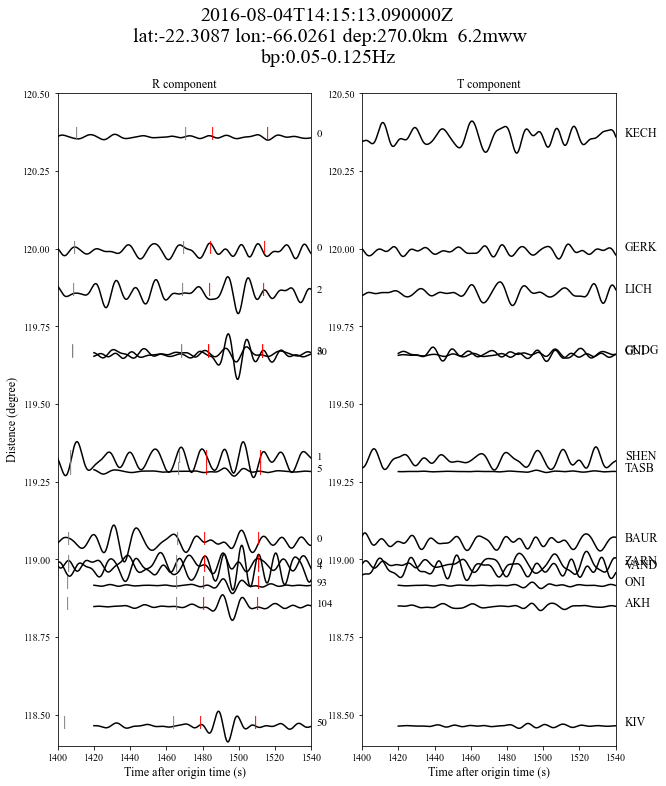

In [29]:
##=============calculate traval time=====================
min_arrivals = model.get_travel_times(source_depth_in_km=depth,distance_in_degree=119.3,phase_list=['SKS'])
for arr in min_arrivals:
    name=arr.phase.name
    if arr.time <1810:
        locals()['min_arr_%s' % (name)]= arr.time

max_arrivals = model.get_travel_times(source_depth_in_km=depth,distance_in_degree=122,phase_list=['SKS'])
for arr in max_arrivals:
    name=arr.phase.name
    if arr.time <1810:       
        locals()['max_arr_%s' % (name)]= arr.time
##=============plot traval time curves====================  
plt.figure(1,figsize=(10,12))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
for phase in Rphase:
    if phase == 'SKS' :
        ph_color = phasecolor[phase]

        try:
            min_arr_t= locals()['min_arr_%s' % (phase)]
            max_arr_t= locals()['max_arr_%s' % (phase)]
            if  min_arr_SKS-20 < min_arr_t < max_arr_SKKKS+20:
                ax1.plot([min_arr_t,max_arr_t],[min(deglist)-0.1,max(deglist)+0.1],color=ph_color,ls='--') 
                ax1.text(max_arr_t,max(deglist)+0.15,phase,c='k',fontsize=8,ma='left',
                         bbox=dict(boxstyle="round",ec=ph_color,fc='white'))
                ax2.plot([min_arr_t,max_arr_t],[min(deglist)-0.1,max(deglist)+0.1],color=ph_color,ls='--',alpha=0.4) 
                ax2.text(max_arr_t,max(deglist)+0.15,phase,c='k',fontsize=8,ma='left',
                         bbox=dict(boxstyle="round",ec=ph_color,fc='white'))
        except : continue
##========================================================

for net in network:
    print(net)
    if net == 'AM' or net == 'TG' :
        NET_DIR = f'{DATA_DIR}{net}'
        eq_DIR =  f'{NET_DIR}/{yyyy}{mm}{dd}{hh}{minn}'
        for path in sorted(glob.glob(f'{eq_DIR}/*Z')):
            
            STA = path.rsplit('.',2)[1]
            print(STA)
            st_lat = (df['lat'][ (df['network'] == net ) & (df['station'] == STA) ]).item()
            st_lon = (df['lon'][ (df['network'] == net ) & (df['station'] == STA) ]).item()

            dist,azi,baz = gps2dist_azimuth(eq_lat,eq_lon,st_lat,st_lon)
            dist = dist/1000
            deg = kilometer2degrees(dist)

            ori_st=Stream()
            for datapath in glob.glob(f'{eq_DIR}/*{STA}*.HH?'):
                tr = read(datapath)
                ori_st += tr
            st = ori_st.copy()
            st.merge(fill_value=0)
            st.detrend('linear');st.detrend('demean');st.taper(0.05,type='cosine')
            st.filter('bandpass',freqmin=freqmin,freqmax=freqmax,corners=4,zerophase=True)
            dt = 1 / st[0].stats.sampling_rate
            try:
                HHE = st.select(component='E')[0].data
                HHN = st.select(component='N')[0].data
                HHZ = st.select(component='Z')[0].data
                HHR,HHT = rotate_ne_rt(HHN,HHE,baz)
                lilikoko(STA,HHR,HHT,deg,st,dt)
            except: pass
    else:
        eq_DIR = f'waveforms/{net}'
        if net == 'II' or net == 'IU': chan = 'BH'
        else: chan = 'HH'
        for path in sorted(glob.glob(f'{eq_DIR}/*/{chan}Z.*2016*')):
            STA = path.rsplit('/')[2]
            print(STA)
            st_lat = (df['lat'][ (df['network'] == net ) & (df['station'] == STA) ]).item()
            st_lon = (df['lon'][ (df['network'] == net ) & (df['station'] == STA) ]).item()
            dist,azi,baz = gps2dist_azimuth(eq_lat,eq_lon,st_lat,st_lon)
            dist = dist/1000
            deg = kilometer2degrees(dist)

            ori_st=Stream()
            for datapath in glob.glob(f'{eq_DIR}/{STA}/{chan}?.*2016*'):
                tr = read(datapath,starttime=eq_time+1420, endtime=eq_time+1550)
                ori_st += tr    
            st = ori_st.copy()
            st.merge(fill_value=0)
            st.detrend('linear');st.detrend('demean');st.taper(0.05,type='cosine')
            st.filter('bandpass',freqmin=freqmin,freqmax=freqmax,corners=4,zerophase=True)
            dt = 1 / st[0].stats.sampling_rate
#             try: 
            if net == 'II' or net == 'IU':
                HHE = st.select(component='2')[0].data
                HHN = st.select(component='1')[0].data
                HHZ = st.select(component='Z')[0].data
                HHR,HHT = rotate_ne_rt(HHN,HHE,baz)
                lilikoko(STA,HHR,HHT,deg,st,dt)
            else: 
                HHE = st.select(component='E')[0].data
                HHN = st.select(component='N')[0].data
                HHZ = st.select(component='Z')[0].data
                HHR,HHT = rotate_ne_rt(HHN,HHE,baz)
                lilikoko(STA,HHR,HHT,deg,st,dt)
#             except: print('papap')
##==========================calculate SNR ========================= 


    plt.suptitle(f'{eq_time}\n lat:{eq_lat} lon:{eq_lon} dep:{depth}km  {mag}{mag_type}\nbp:{freqmin}-{freqmax}Hz', 
             fontsize=20)
        
        
        
plt.savefig('SNR_waveform_20160804.png',dpi=200)
plt.savefig('SNR_waveform_20160804.pdf')       
        
        
        
        
        
        

In [19]:
st

2 Trace(s) in Stream:
.BYUR..HHN | 2016-08-04T14:15:13.000000Z - 2016-08-04T14:45:12.990000Z | 100.0 Hz, 180000 samples
.BYUR..HHZ | 2016-08-04T14:15:13.000000Z - 2016-08-04T14:45:12.990000Z | 100.0 Hz, 180000 samples

## Download waveform

In [12]:
from obspy.clients.fdsn.mass_downloader import RectangularDomain, \
    Restrictions, MassDownloader

In [18]:
domain = RectangularDomain(minlatitude=-90, maxlatitude=90,
                           minlongitude=-180, maxlongitude=180)

restrictions = Restrictions(
    # Get data for a whole year.
    starttime=eq_time,
    endtime=eq_time+30*60,
    # Chunk it to have one file per day.
    chunklength_in_sec=86400,
    # Considering the enormous amount of data associated with continuous
    # requests, you might want to limit the data based on SEED identifiers.
    # If the location code is specified, the location priority list is not
    # used; the same is true for the channel argument and priority list.
    network="KO", station="BCA", location="", channel="HH*",
    # The typical use case for such a data set are noise correlations where
    # gaps are dealt with at a later stage.
    reject_channels_with_gaps=False,
    # Same is true with the minimum length. All data might be useful.
    minimum_length=0.0,
    # Guard against the same station having different names.
    minimum_interstation_distance_in_m=100.0)

# Restrict the number of providers if you know which serve the desired
# data. If in doubt just don't specify - then all providers will be
# queried.
mdl = MassDownloader()
mseed_storage = ("waveforms/{network}/{station}/"
                 "{channel}.{location}.{starttime}.{endtime}.mseed")
mdl.download(domain, restrictions, mseed_storage=mseed_storage,
             stationxml_storage="stations")

[2022-04-28 14:04:02,549] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for BGR, EMSC, ETH, GEONET, GFZ, ICGC, INGV, IPGP, ISC, KNMI, KOERI, LMU, NCEDC, NIEP, NOA, RESIF, SCEDC, TEXNET, UIB-NORSAR, USGS, USP, ORFEUS, IRIS.
[2022-04-28 14:04:02,571] - obspy.clients.fdsn.mass_downloader - INFO: Cannot use client 'EMSC' as it does not have 'dataselect' and/or 'station' services.
[2022-04-28 14:04:02,590] - obspy.clients.fdsn.mass_downloader - INFO: Cannot use client 'ISC' as it does not have 'dataselect' and/or 'station' services.
[2022-04-28 14:04:02,624] - obspy.clients.fdsn.mass_downloader - INFO: Cannot use client 'USGS' as it does not have 'dataselect' and/or 'station' services.
[2022-04-28 14:04:03,225] - obspy.clients.fdsn.mass_downloader - WARNING: Failed to initialize client 'TEXNET'.
[2022-04-28 14:04:03,226] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 19 client(s): BGR, ETH, GEONET, GFZ, ICGC, INGV, IPGP, KNMI, KOERI, LMU, NC

{'BGR': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0x7ff914c26100>,
 'ETH': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0x7ff912e630a0>,
 'GEONET': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0x7ff914cfddc0>,
 'GFZ': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0x7ff914cfdf40>,
 'ICGC': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0x7ff914cfdee0>,
 'INGV': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0x7ff914cfdf70>,
 'IPGP': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0x7ff90ff32f40>,
 'KNMI': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0x7ff90ff323a0>,
 'KOERI': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0x7ff90ff32ee0>,
 'LMU': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownlo